In [1]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scale_bar import add_scalebar

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

dataset = 2
import mnist_reader 
    
X_train, y_train = mnist_reader.load_mnist('../data/mnist', kind='train')
X_test, y_test = mnist_reader.load_mnist('../data/mnist', kind='t10k')

#n = 2000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n, replace=False)
#X_train, y_train = X_train[ids], y_train[ids]

X_train = X_train.astype(np.float32)
max_val = np.max(X_train)
X_train = X_train/max_val

X_test = X_test/max_val

n = X_train.shape[0]

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

print(X_train.shape, y_train.shape, X_train.dtype)

#Torch Setups
from sklearn.decomposition import PCA

#import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#X_torch = torch.as_tensor(X_train, dtype=torch.float32, device=device)

n_components = 2

pca = PCA(n_components = n_components)
x_init = pca.fit_transform(X_train)
x_init = x_init - np.mean(x_init, axis=0)

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

print('Training Statistics')
print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32
Training Statistics
size:  (60000, 784)
Mean: 0.13066062
Max:  1.0
Min:  0.0
STD:  0.30810776


<IPython.core.display.Javascript object>


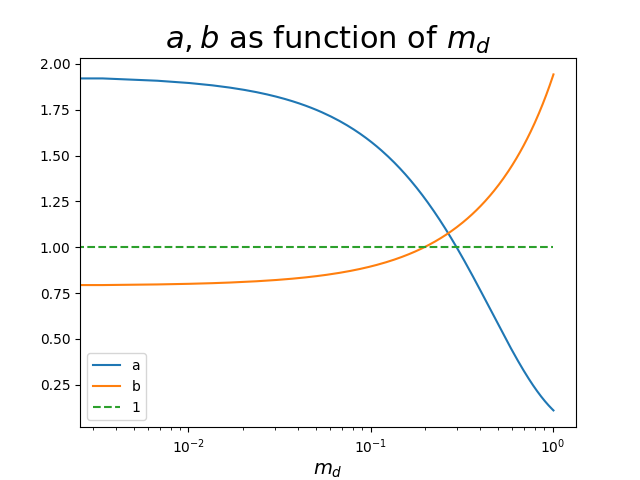

0.9921756197688717 1.1122533842193434


In [2]:
from scipy.optimize import curve_fit

def find_ab_params(min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    ####code adapted from UMAP github repo
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist))
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

def derivative_f_zeta(zeta,a,b):
    pass

a_1,b_1 = find_ab_params(0.1)

min_dists = np.linspace(0,1.01,300)

a_s = []
b_s = []

for md in min_dists:
    a_x, b_x = find_ab_params(md)
    a_s.append(a_x)
    b_s.append(b_x)
    
plt.figure()
plt.plot(min_dists, a_s, label='a')
plt.plot(min_dists, b_s, '-', label='b')
plt.plot([0,1.01], [1,1], '--', label='1')

plt.xlabel(r'$m_d$', fontsize=14)

plt.xscale('log')

plt.title(r'$a,b$ as function of $m_d$', fontsize=22)

plt.legend()
plt.savefig('fig_repul/ab_plot.svg')


a_m,b_m = find_ab_params(0.3)
print(a_m,b_m)

In [3]:
def rep_ceoff_fun(dist,a,b):
    return 2 * b / (dist**2 * (1 + a*dist**(2*b)))

def attr_coeff_fun(dist, a,b):
    return -2*a*b*dist**(2*(b-1)) / (1+a*dist**(2*b))

dists=np.arange(0.01,4,0.01)

(60000, 2)


<IPython.core.display.Javascript object>


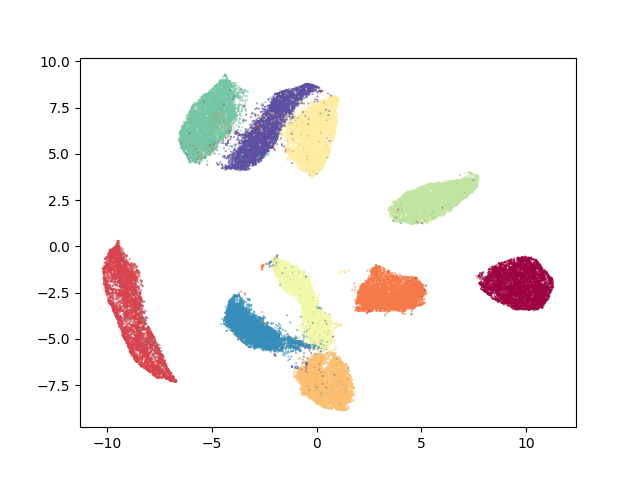

In [4]:
from procrustes import procrustes_distances

fname = '../MNIST_exp_with_attraction_shapes/random_init_test_orig/'

with open(fname+'mnist_PCA_init.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')

Procrusted Distance: Mean:  0.2791561636245063  STD:  0.19243939132473714
(11, 3)
0 [1.57694346e+00 8.95060878e-01 2.00000000e-04]
1 [1.57694346e+00 8.95060878e-01 3.00000000e-04]
2 [1.57694346e+00 8.95060878e-01 4.00000000e-04]
3 [1.57694346e+00 8.95060878e-01 5.00000000e-04]
4 [1.57694346e+00 8.95060878e-01 6.00000000e-04]
5 [1.57694346e+00 8.95060878e-01 1.00000000e-03]
6 [1.57694346 0.89506088 0.002     ]
7 [1.57694346 0.89506088 0.003     ]
8 [1.57694346 0.89506088 0.004     ]
9 [1.57694346 0.89506088 0.005     ]
10 [1.57694346 0.89506088 0.006     ]


<IPython.core.display.Javascript object>


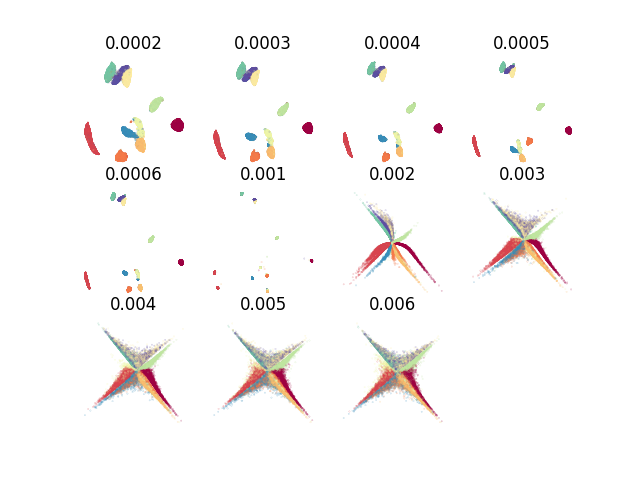

In [5]:
with open('embeddings/varying_limit_2.npy', 'rb') as f:
    emblim_orig = np.load(f)
    param_lim = np.load(f)
    

pdslim, emblim = procrustes_distances(umap_pca,emblim_orig)

print(param_lim.shape)
    
lim_values = param_lim[:,2]

for i in range(len(lim_values)):
    print(i, param_lim[i])
    
plt.figure()
k = 0
for k in range(11):
    plt.subplot(3,4,k+1)
    plt.scatter(emblim[k,:,0], emblim[k,:,1], c=y_train, s=0.01, cmap='Spectral')
    plt.axis('off')
    plt.title(lim_values[k])
    

0.0002


<IPython.core.display.Javascript object>


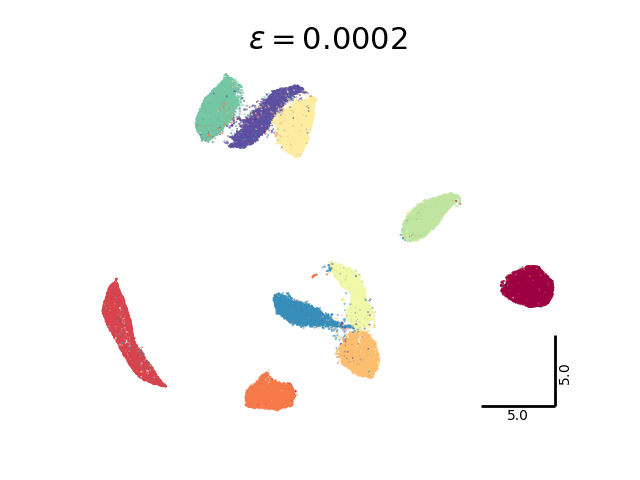

$\varepsilon=0.0002$
0.0004


<IPython.core.display.Javascript object>


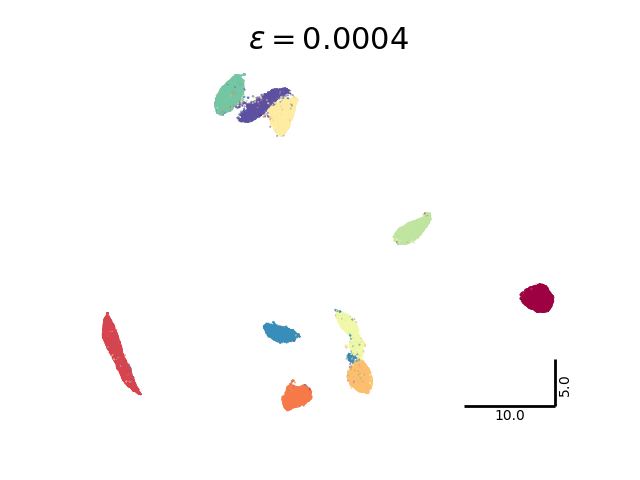

$\varepsilon=0.0004$
0.0006


<IPython.core.display.Javascript object>


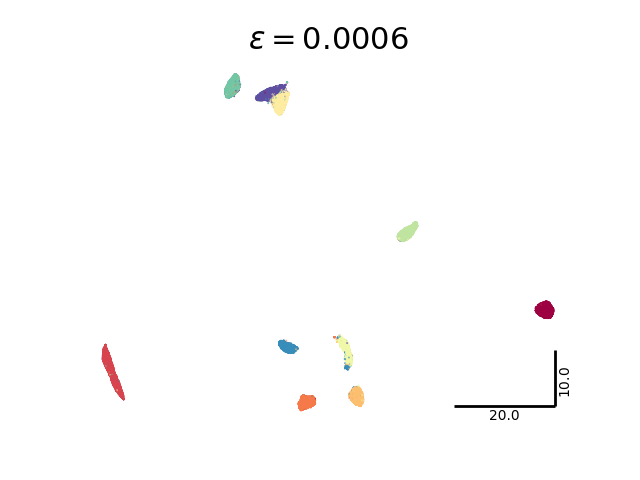

$\varepsilon=0.0006$


In [6]:
indexes = [0,2,4]

RS =[]
PS = []


for i in indexes:
    emb = emblim[i]
    print(lim_values[i])
    
    a, b, lim = param_lim[i]
    RS.append(rep_ceoff_fun(dists, a, b)+lim)
    PS.append(param_lim[i])
    
    fig, ax = plt.subplots()
    plt.scatter(emb[:,0], emb[:,1], c=y_train, s=0.1, cmap='Spectral')
    add_scalebar(ax, loc=4, barwidth=2)
    title_str = r'$\varepsilon='+str(lim)+'$'
    print(title_str)
    plt.title(title_str, fontsize=22)
    
    plt.savefig('fig_repul/limit_'+str(lim_values[i])+'_.png',dpi=400)
    


<IPython.core.display.Javascript object>


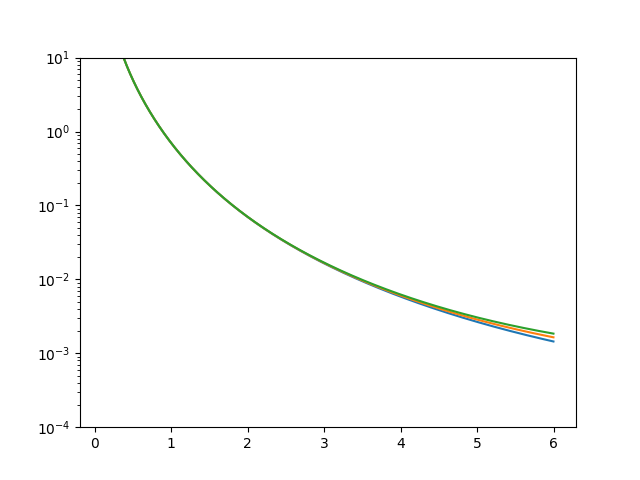

In [7]:
dists = np.arange(0.1,6,0.001)
plt.figure()

RS_lim = []
RS_val = []
for i in indexes:
    a, b, lim = param_lim[i]
    RS = rep_ceoff_fun(dists, a, b)+lim
    RS_lim.append(RS)
    RS_val.append(param_lim[i])
    plt.plot(dists,RS,label=r'$\epslion='+str(lim)+'$')


plt.yscale('log')
plt.ylim([0.0001,10])
plt.legend()

<h1>Varying m_d</h1>

0 [4.34603780e-04 3.89121697e+00 2.00000000e+00]
1 [0.11497568 1.92923715 1.        ]
2 [0.58303002 1.33416699 0.5       ]
3 [1.26205812 1.0030054  0.2       ]
4 [1.57694346 0.89506088 0.1       ]
5 [1.89560587 0.80063784 0.01      ]
6 [1.92907340e+00 7.91504533e-01 1.00000000e-03]
7 [1.93243475e+00 7.90595882e-01 1.00000000e-04]
8 [1.93277103e+00 7.90505064e-01 1.00000000e-05]
9 [1.93280802e+00 7.90495074e-01 1.00000000e-07]


<IPython.core.display.Javascript object>


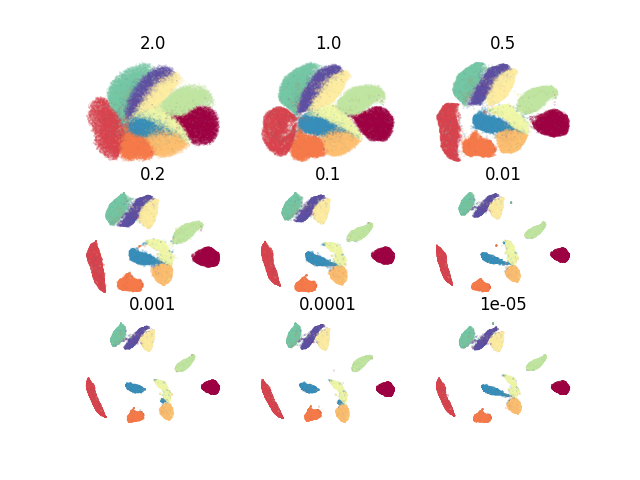

In [8]:
with open('embeddings/varying_md.npy', 'rb') as f:
    embmd = np.load(f)
    md_param = np.load(f)
    
for i in range(len(md_param)):
    print(i, md_param[i])

plt.figure()
k = 0
for i in range(9):
    plt.subplot(3,3,k+1)
    plt.scatter(embmd[k,:,0], embmd[k,:,1], c=y_train, cmap='Spectral', s=0.01)
    plt.title(md_param[k,2])
    plt.axis('off')
    k=k+1

0.1


<IPython.core.display.Javascript object>


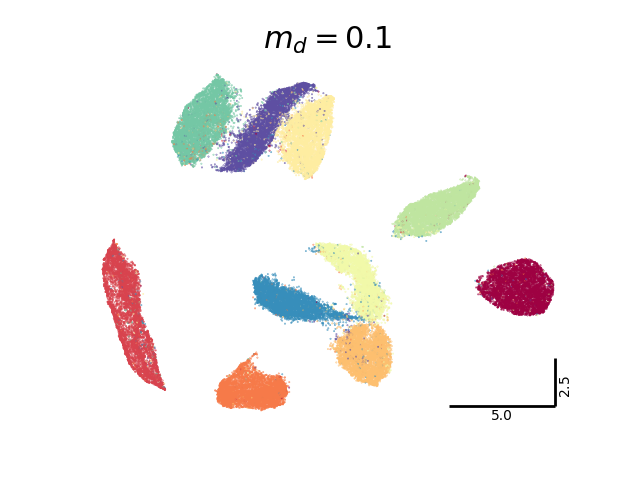

0.01


<IPython.core.display.Javascript object>


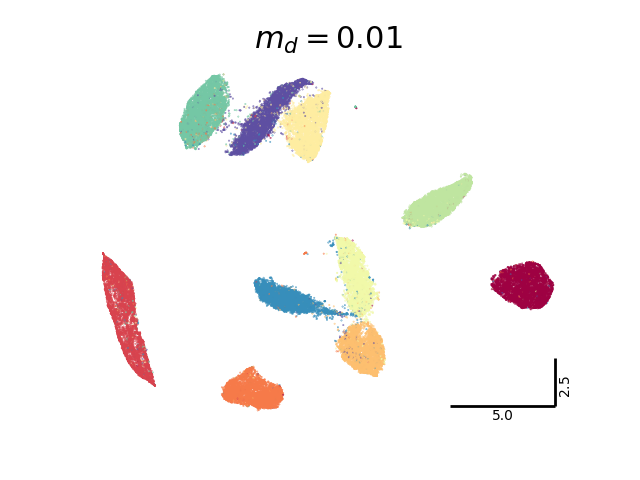

0.0001


<IPython.core.display.Javascript object>


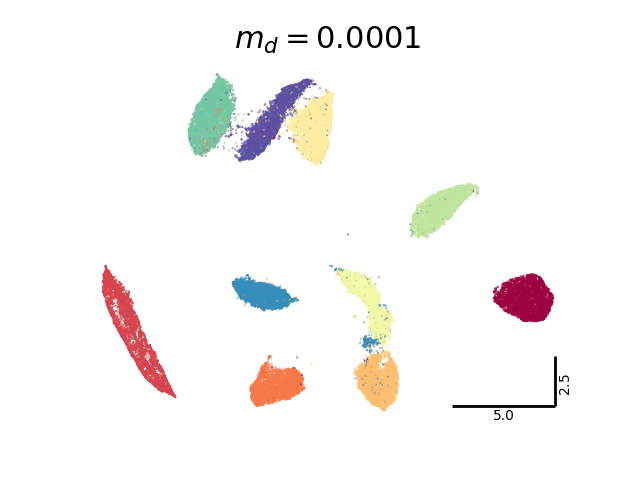

In [9]:
indexes_md = [4,5,7]


for i in indexes_md:
    emb = embmd[i]
    print(md_param[i,2])
    
    fig, ax = plt.subplots()
    plt.scatter(emb[:,0], emb[:,1], c=y_train, s=0.1, cmap='Spectral')
    add_scalebar(ax, loc=4, barwidth=2)
    plt.title(r'$m_d='+str(md_param[i,2])+'$', fontsize=22)
    
    plt.savefig('fig_repul/md_'+str(md_param[i,2])+'_.png',dpi=400)


<h1> Varying b</h1>

0 [1.57694346 1.8       ]
1 [1.57694346 1.5       ]
2 [1.57694346 1.        ]
3 [1.57694346 0.9       ]
4 [1.57694346 0.8       ]
5 [1.57694346 0.6       ]
6 [1.57694346 0.5       ]
7 [1.57694346 0.4       ]
8 [1.57694346 0.3       ]


<IPython.core.display.Javascript object>


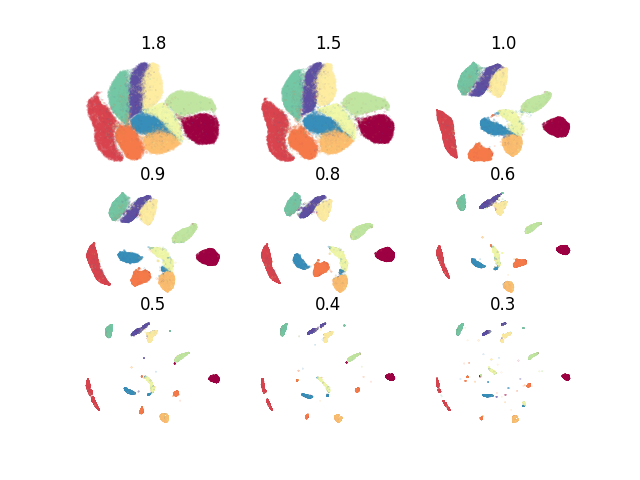

In [10]:
with open('embeddings/varying_b.npy', 'rb') as f:
    embb = np.load(f)
    b_param = np.load(f)
    
for i in range(len(b_param)):
    print(i, b_param[i])


plt.figure()
k = 0
for i in range(len(b_param)):
    plt.subplot(3,3,k+1)
    plt.scatter(embb[k,:,0], embb[k,:,1], c=y_train, cmap='Spectral', s=0.01)
    plt.title(b_param[i,1])
    plt.axis('off')
    k=k+1
    

0.6


<IPython.core.display.Javascript object>


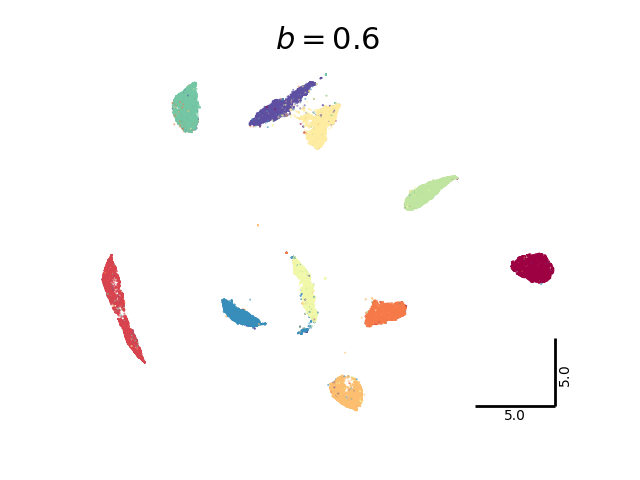

0.5


<IPython.core.display.Javascript object>


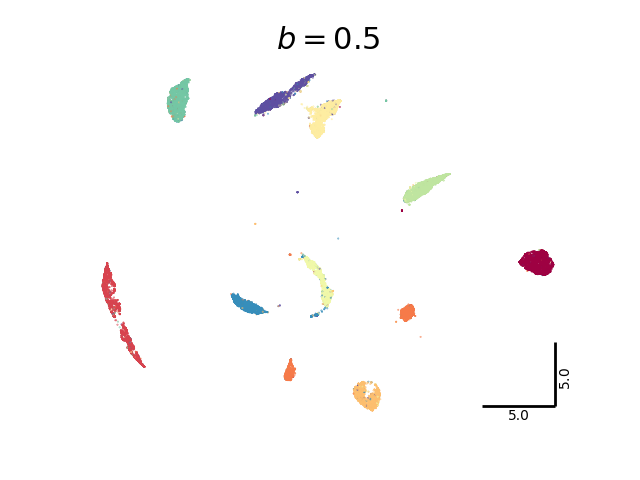

0.4


<IPython.core.display.Javascript object>


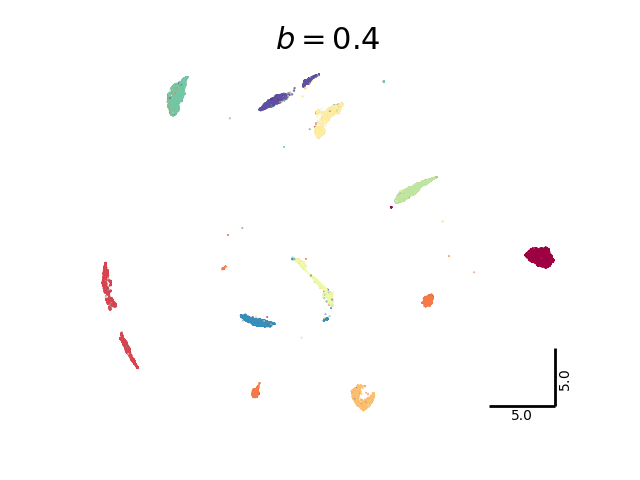

In [11]:
indexes_b = [5,6,7]


for i in indexes_b:
    emb = embb[i]
    print(b_param[i,1])
    
    fig, ax = plt.subplots()
    plt.scatter(emb[:,0], emb[:,1], c=y_train, s=0.1, cmap='Spectral')
    add_scalebar(ax, loc=4, barwidth=2)
    plt.title(r'$b='+str(b_param[i,1])+'$', fontsize=22)
    
    plt.savefig('fig_repul/b_'+str(b_param[i,1])+'_.png',dpi=400)


/tmp/ipykernel_6095/573484926.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


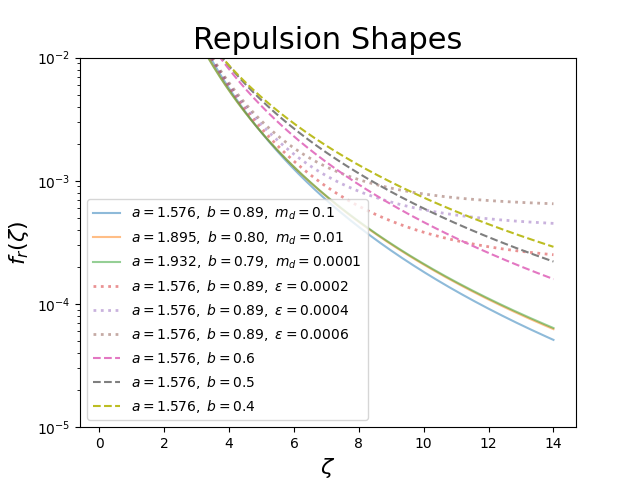

In [17]:
dists = np.arange(0.1,14,0.001)
plt.figure()

RS_md = []
RS_val_md = []
for i in indexes_md:
    a, b, md = md_param[i]
    RS = rep_ceoff_fun(dists, a, b)
    RS_md.append(RS)
    RS_val_md.append(md_param[i])
    plt.plot(dists,RS,
             label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+',~m_d='+str(md)+'$',
             alpha=0.5)




RS_lim = []
RS_val = []
for i in indexes:
    a, b, lim = param_lim[i]
    RS = rep_ceoff_fun(dists, a, b)+lim
    RS_lim.append(RS)
    RS_val.append(param_lim[i])
    plt.plot(dists,RS, ':',
             label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+',~\epsilon='+str(lim)+'$', 
             alpha=0.5, linewidth=2.0)
    
    
RS_b = []
RS_val_b = []
for i in indexes_b:
    a,b = b_param[i]
    RS = rep_ceoff_fun(dists, a, b)
    RS_b.append(RS)
    RS_val_b.append(b_param[i])
    plt.plot(dists,RS, '--',
             label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', 
             alpha=1.0)


plt.xlabel(r'$\zeta$',fontsize=16)
plt.ylabel(r'$f_r(\zeta)$',fontsize=16)
plt.title('Repulsion Shapes', fontsize=22)


plt.legend()
plt.yscale('log')
plt.ylim([0.00001,0.01])

plt.show()

plt.savefig('fig_repul/repulsion_shapes.svg')

<IPython.core.display.Javascript object>


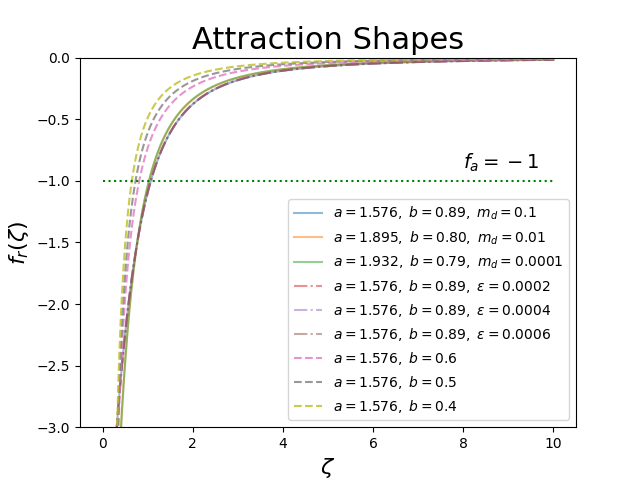

In [13]:
dists = np.arange(0.001,10,0.001)
plt.figure()

RS_md = []
RS_val_md = []
for i in indexes_md:
    a, b, md = md_param[i]
    RS = attr_coeff_fun(dists, a, b)
    RS_md.append(RS)
    RS_val_md.append(md_param[i])
    plt.plot(dists,RS,label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+',~m_d='+str(md)+'$',alpha=0.5)




RS_lim = []
RS_val = []
for i in indexes:
    a, b, lim = param_lim[i]
    RS = attr_coeff_fun(dists, a, b)+lim
    RS_lim.append(RS)
    RS_val.append(param_lim[i])
    plt.plot(dists,RS, '-.',label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+',~\epsilon='+str(lim)+'$', alpha=0.5)
    
    
RS_b = []
RS_val_b = []
for i in indexes_b:
    a,b = b_param[i]
    RS = attr_coeff_fun(dists, a, b)
    RS_b.append(RS)
    RS_val_b.append(b_param[i])
    plt.plot(dists,RS, '--',label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', alpha=0.8)

    
plt.text(8, -.9, r'$f_a=-1$', fontsize=14)
umap_a = [-1, -1]
umap_x = [0.0, 10.0]
plt.plot(umap_x,umap_a, c='g', ls=':')

plt.xlabel(r'$\zeta$',fontsize=16)
plt.ylabel(r'$f_r(\zeta)$',fontsize=16)
plt.title('Attraction Shapes', fontsize=22)


plt.legend()
#plt.yscale('log')
plt.ylim([-3,0])

plt.show()

plt.savefig('fig_repul/attraction_shapes.svg')

<h1>Other Graphs</h1>

<IPython.core.display.Javascript object>


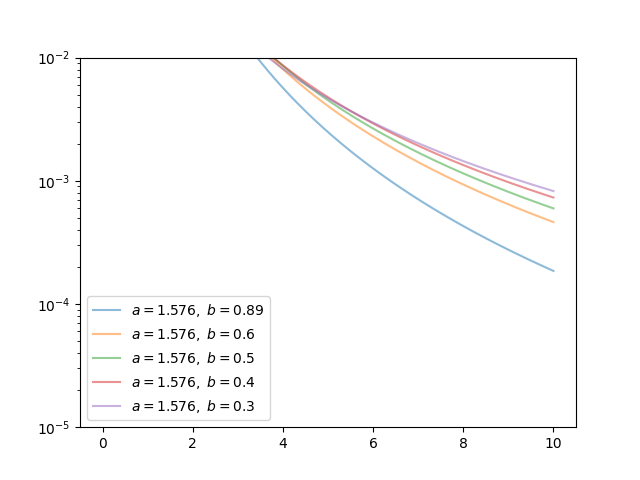

<IPython.core.display.Javascript object>


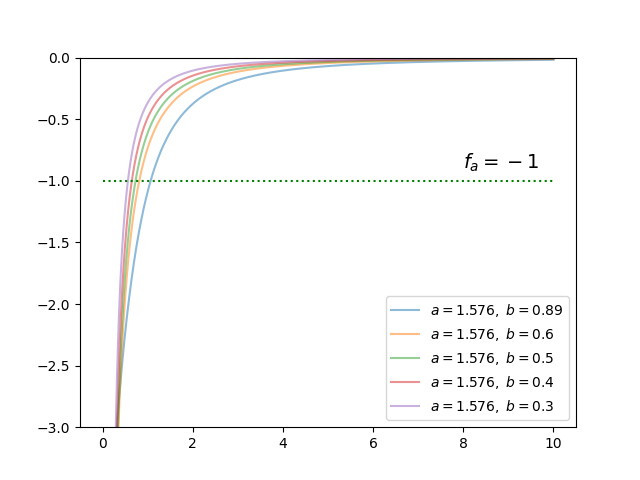

In [14]:
a = 1.576
bs = [0.89, 0.6, 0.5, 0.4, 0.3]

RS_bs = []
plt.figure()
for b in bs:
    RS = rep_ceoff_fun(dists, a, b)
    RS_bs.append(RS)
    plt.plot(dists,RS,label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', alpha=0.5)
    
plt.legend()
plt.yscale('log')
plt.ylim([0.00001,0.01])


AS_bs = []
plt.figure()
for b in bs:
    AS = attr_coeff_fun(dists, a, b)
    AS_bs.append(AS)
    plt.plot(dists,AS,label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', alpha=0.5)
    
plt.ylim([-3,0])

plt.text(8, -.9, r'$f_a=-1$', fontsize=14)
umap_a = [-1, -1]
umap_x = [0.0, 10.0]
plt.plot(umap_x,umap_a, c='g', ls=':')


plt.legend()


<IPython.core.display.Javascript object>


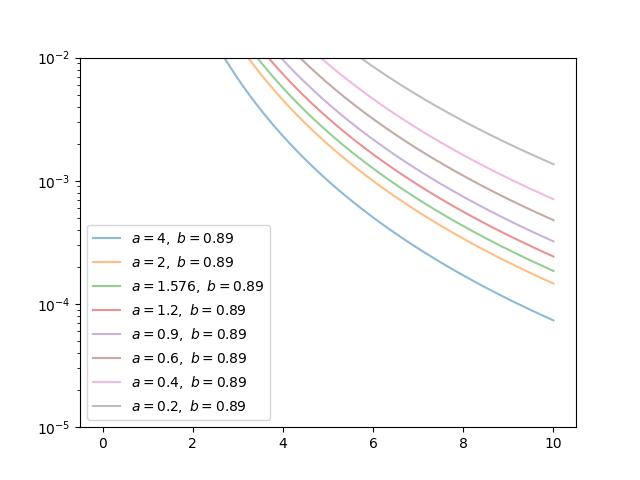

/tmp/ipykernel_6095/781718755.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


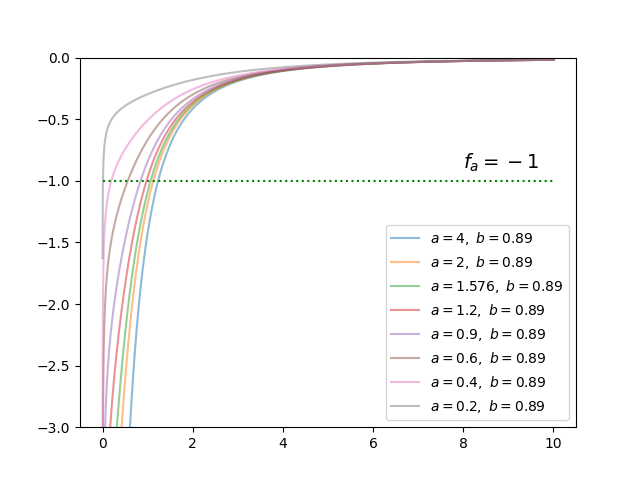

(-3.0, 0.0)

In [15]:
a_s = [4,2,1.576,1.2,0.9,0.6,0.4,0.2]
b = 0.89 #[0.89, 0.6, 0.5, 0.4, 0.3]

RS_as = []
plt.figure()
for a in a_s:
    RS = rep_ceoff_fun(dists, a, b)
    RS_as.append(RS)
    plt.plot(dists,RS,label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', alpha=0.5)
    
plt.legend()
plt.yscale('log')
plt.ylim([0.00001,0.01])


AS_as = []
plt.figure()
for a in a_s:
    AS = attr_coeff_fun(dists, a, b)
    AS_as.append(AS)
    plt.plot(dists,AS,label=r'$a='+str(a)[:5]+',~b='+str(b)[:4]+'$', alpha=0.5)
    
plt.text(8, -.9, r'$f_a=-1$', fontsize=14)
umap_a = [-1, -1]
umap_x = [0.0, 10.0]
plt.plot(umap_x,umap_a, c='g', ls=':')

plt.legend()
plt.ylim([-3,0])
